# Summary
Trabalho 3

Thiago Bruschi Martins RA: 120212

Objetivo do trabalho: Explorar diferentes técnicas em busca do melhor resultado para a previsão de uma série temporal (Preço do Ouro).
Dois problemas são tratados aqui: 

1.   Problema de regressão: previsão do preço do ouro no dia seguinte
2.   Problema de classificação: prever se o preço do ouro vai subir ou descer

# Preprocessing

In [1]:
import matplotlib.pyplot as plt
from datetime import datetime
import io
import random
import requests
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from scipy.stats import loguniform, uniform
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV


url = "https://www.ic.unicamp.br/~wainer/cursos/1s2021/432/ouro2.csv"
s = requests.get(url).content
dateparse = lambda x: datetime.strptime(x, '%d/%m/%Y') # needed for reading the brasilian date format
df = pd.read_csv(io.StringIO(s.decode('utf-8')), parse_dates=['Data'], index_col='Data', date_parser=dateparse) # dates became index
df.rename(columns={'Valor':'value'}, index={'Data':'date'}, inplace=True) # index rename it's not working, idk why
df.index.name='date'

plt.style.use('seaborn')
df_i = df[::-1]
X = df_i.iloc[0:-100].asfreq('W') # keep the last 100 observations for the test
#X = X.loc['2001':] # Remove the first year because it's not complete
y_test = df_i.iloc[-100:]

print(X.tail())
print(y_test.head())

             value
date              
2019-06-16  1432.7
2019-06-23  1446.8
2019-06-30  1436.6
2019-07-07  1450.9
2019-07-14  1465.5
             value
date              
2019-07-21  1460.4
2019-07-28  1485.3
2019-08-04  1534.5
2019-08-11  1549.2
2019-08-18  1563.5


In [5]:
import warnings
# Hide warnings
warnings.filterwarnings("ignore")

# Global variables
results = {}
best = {}
X_train = pd.DataFrame()
X_test = pd.DataFrame()
y_train = pd.DataFrame()
y_test = pd.DataFrame()

range_window = [1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 30, 40]

# Functions

In [6]:
# Testa 10 valores de parâmetros aleatórios no estimator recebido
def random_search(estimator, param_distributions):
  rscv = RandomizedSearchCV(estimator, param_distributions=param_distributions, scoring='neg_root_mean_squared_error', n_iter=10, n_jobs=-1)
  r = rscv.fit(X_train,y_train)
  return -r.best_score_, r.best_params_

# Realiza o cross_validation com os valores padrões do estimator recebido
def cross_validation(estimator):
  r = cross_val_score(estimator, X_train, y_train, cv=5, scoring='neg_root_mean_squared_error')
  return np.min(-r)

def list_dict(d):
    for x in d:
        print (f'\t{x}: {d[x]}')     

def print_dict(d):
    for x in d:
        print (x)
        for y in d[x]:
            print ('\t',y,':', d[x][y])

# Testa um modelo com os parâmetros recebidos e com os valores default
def model_test(estimator, params, name):
  best_score, best_params = random_search(estimator, params)
  default_score =  cross_validation(estimator)
  full_params = estimator.get_params()
  default_params = { k: full_params[k] for k in list(params.keys()) }

  results[name] = {}
  results[name]['best_score'] = best_score
  results[name]['default_score'] = default_score
  return best_params, default_params

def model_report(name, best_params):
  print(name)
  list_dict(best_params)
  list_dict(results[name])

def lag_data(data, lags=10):
  name = 'shifted_1'
  data[name] = data.shift(1)

  for i in range(2,lags+1):
      last = 'shifted_' + str(i-1)
      name = 'shifted_' + str(i)
      data[name] = data[last].shift(1)
      
  return data.dropna()


def plot_goldprice(predicted_price):
  y_test.reset_index(drop=True, inplace=True)
  plt.plot(y_test, color = 'red', label = 'Preço real')
  plt.plot(predicted_price, color = 'blue', label = 'Previsões')
  plt.title('Previsão preço do ouro')
  plt.xlabel('Tempo')
  plt.ylabel('Valor')
  plt.legend()
  plt.show()

def adjust_window(window):
  global X_train, y_train, X_test, y_test

  # Dados de treino
  X_train = X.copy()
  X_train = lag_data(X_train, window)
  y_train = X_train.value.shift(-1).dropna()
  X_train.drop(X_train.tail(1).index,inplace=True)

  # Dados de teste
  X_test = df_i.copy()
  X_test = lag_data(X_test, window).iloc[-100:] #df_lagged.iloc[-100:]
  X_test.shape
  y_test = X_test.value.shift(-1).dropna()
  X_test.drop(X_test.tail(1).index, inplace=True)
  y_test.reset_index(drop=True, inplace=True)
  

def model_test_window(estimator, params, name):
  best[name] = {'best_score':99999}
  
  for w in range_window:
    adjust_window(w)    
    best_params, default_params = model_test(estimator, params, name)
    best_score = min(results[name]['best_score'], results[name]['default_score'])

    if best_score < best[name]['best_score']:
      best[name]['best_score'] = best_score
      best[name]['window'] = w

      if results[name]['best_score'] < results[name]['default_score']:
        best[name]['best_params'] = best_params
      else:
        best[name]['best_params'] = default_params
    
  print(best[name])

def test_and_plot(model, params, name):
  model_test_window(model(), params, name)

  m = model(**best[name]['best_params'])
  m.fit(X_train, y_train)
  r = m.predict(X_test)
  plot_goldprice(r)



# Regressors

## Linear Models

### Linear

{'best_score': 7.944700559279386, 'window': 1, 'best_params': {}}


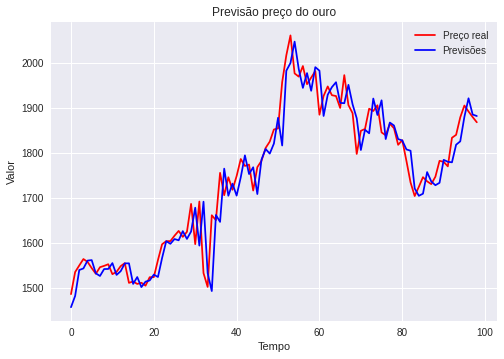

In [ ]:
test_and_plot(LinearRegression, {}, 'Linear')

### Lasso

{'best_score': 7.946468133786629, 'window': 1, 'best_params': {'alpha': 1.0}}


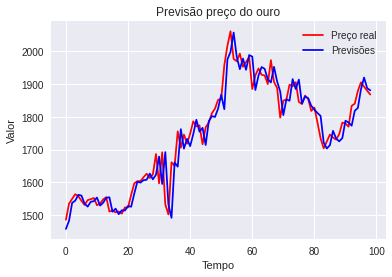

In [7]:
lasso_param = {
    'alpha':loguniform(10e-3, 10e3)
}

test_and_plot(Lasso, lasso_param, 'Lasso')

### Ridge

{'best_score': 7.944703200362377, 'window': 1, 'best_params': {'alpha': 1.0}}


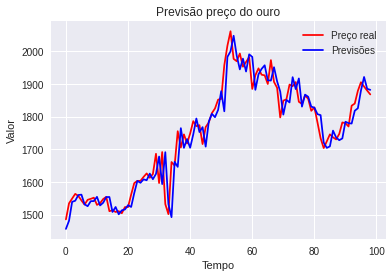

In [9]:
ridge_param = {
    'alpha':loguniform(10e-3, 10e3)
}

test_and_plot(Ridge, ridge_param, 'Ridge')

## KNN

{'best_score': 24.118892925662983, 'window': 1, 'best_params': {'n_neighbors': 5}}


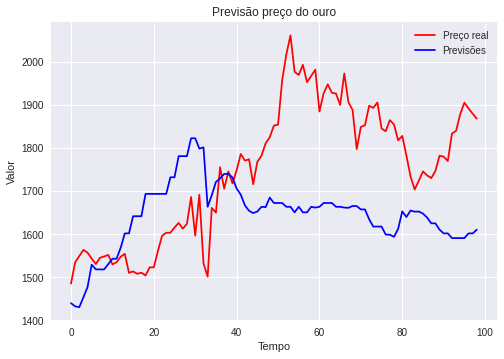

In [ ]:
knn_params = {
    'n_neighbors':np.random.randint(1, 500, 10)
    }

test_and_plot(KNeighborsRegressor, knn_params, 'KNN')

## MLP

{'best_score': 6.8753610183251785, 'window': 2, 'best_params': {'hidden_layer_sizes': (100,)}}


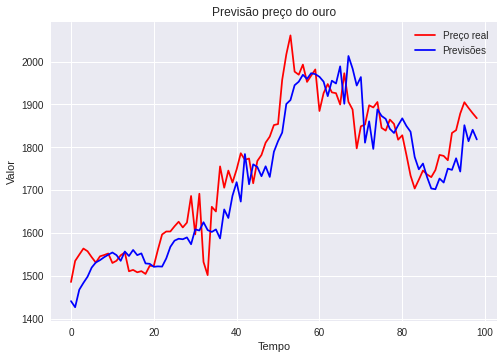

In [ ]:
MLP_params = {
    'hidden_layer_sizes':(5,8,11,14,17,20,23, 30, 40, 50, 100, 150, 200)
    }

test_and_plot(MLPRegressor, MLP_params, 'MLP')

## GBM

{'best_score': 23.905103044486253, 'window': 1, 'best_params': {'n_estimators': 100, 'max_depth': 3}}


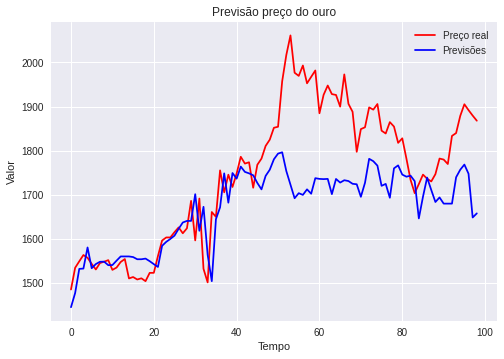

In [ ]:
gbm_params = {
    'n_estimators': np.random.randint(5, 1000, 10),
    'max_depth':[10, 50, 100, 400, 4000]
    }

test_and_plot(GradientBoostingRegressor, gbm_params, 'GBM')

# Classifiers

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

def float_to_cat(col):
  difference = col.diff().dropna()
  #difference[0] = 1 # just to fill the NaN
  bins = [-np.inf, 0, np.inf]
  return pd.cut(difference, bins=bins, labels=[0, 1])


def classifier_test(estimator):
  for w in [1, 4, 8, 20, 40]:
    c_Xtrain = pd.DataFrame()
    c_Xest = pd.DataFrame()

    adjust_window(w) 

    for c in X_train.columns:
      c_Xtrain[c] = float_to_cat(X_train[c])
      c_Xest[c] = float_to_cat(X_test[c])

    c_yTrain = float_to_cat(y_train)
    c_yTest = float_to_cat(y_test)

    model = estimator()
    model.fit(c_Xtrain, c_yTrain)
    pred = model.predict(c_Xest)
    print(f'Model: {estimator.__name__}, Window size:{w}, Accuracy:{accuracy_score(c_yTest, pred)}')
  print()


classifier_test(LogisticRegression)
classifier_test(KNeighborsClassifier)
classifier_test(RandomForestClassifier)
classifier_test(SVC)

Model: LogisticRegression, Window size:1, Accuracy:0.5816326530612245
Model: LogisticRegression, Window size:4, Accuracy:0.5816326530612245
Model: LogisticRegression, Window size:8, Accuracy:0.5816326530612245
Model: LogisticRegression, Window size:20, Accuracy:0.5306122448979592
Model: LogisticRegression, Window size:40, Accuracy:0.4897959183673469

Model: KNeighborsClassifier, Window size:1, Accuracy:0.5102040816326531
Model: KNeighborsClassifier, Window size:4, Accuracy:0.5408163265306123
Model: KNeighborsClassifier, Window size:8, Accuracy:0.5204081632653061
Model: KNeighborsClassifier, Window size:20, Accuracy:0.5
Model: KNeighborsClassifier, Window size:40, Accuracy:0.5510204081632653

Model: RandomForestClassifier, Window size:1, Accuracy:0.5816326530612245
Model: RandomForestClassifier, Window size:4, Accuracy:0.5612244897959183
Model: RandomForestClassifier, Window size:8, Accuracy:0.4489795918367347
Model: RandomForestClassifier, Window size:20, Accuracy:0.5816326530612245
Mo

# Final Report

In [ ]:
print_dict(best)

KNN
	 best_score : 24.118892925662983
	 window : 1
	 best_params : {'n_neighbors': 5}
MLP
	 best_score : 6.8753610183251785
	 window : 2
	 best_params : {'hidden_layer_sizes': (100,)}
GBM
	 best_score : 23.905103044486253
	 window : 1
	 best_params : {'n_estimators': 100, 'max_depth': 3}
LR
	 best_score : 7.944700559279386
	 window : 1
	 best_params : {}
